<h1>HW 4</h1>
Matt Buchovecky  
Astro 283

<h3>Reperform the fit and do a source subtraction again</h3>
I will first do a quick repeat of the fit from last time. I then subtract the best fit of the star from the original data in each bin to get a subtracted map

In [121]:
import numpy
from astropy.io import fits 
from scipy import optimize, ndimage
from matplotlib import pyplot, cm
%matplotlib inline 



In [4]:
star_fits = fits.open("./hw3prob1-data.fits")
star_data = star_fits[0].data
star_rav = star_data.ravel()



Note: The flux parameter we got last time more corresponded to a flux density that fit into this function:  

$$  f\left(x,y,\vec z\right) = Fexp{\left[-\frac{\left(x-x_c\right)^2+\left(y-y_c\right)^2}{2\sigma_{PSF}^2}\right]} $$  
However the total flux of the star would be this function integrated over all space, which would essentially multiply the parameter $F$ by the integral of the gaussian, which for a symmetric 2-D space gives:  
$$ F_{tot} = F * \left(2\pi\sigma^2\right) $$

I think to do the whole thing correctly, the predicted flux in each bin will be the flux density $F$ integrated over the bounds of the cell. It seems the method used before worked well because the bins are very small, so the gaussian function is roughly constant over their area, and we're working in spatial units of bins, so their area happens to be 1. The results may come out better if this is done more rigorously, perhaps with 64 bit floats. The subtraction and the chi square come out nicely though, so this is something I will investigate after turning this in :/

In [5]:
def symm_2d_gaussian(pos, F, xc, yc, sigma, B):
    return F*numpy.exp(-((pos[0]-xc)**2+(pos[1]-yc)**2)/(2*sigma**2)) + B
    

In [112]:
x_bins = star_data.shape[0]
y_bins = star_data.shape[1]

# Create x and y indices
x_arr = numpy.linspace(0, x_bins-1, x_bins)
y_arr = numpy.linspace(0, y_bins-1, y_bins)
x_arr, y_arr = numpy.meshgrid(x_arr, y_arr)
coords = x_arr, y_arr

x_rav = x_arr.ravel()
y_rav = y_arr.ravel()

pi = numpy.pi

In [7]:
init_guess = (50, 130, 130, 20, 100)
sigma_array = numpy.sqrt(star_data)
p_opt_singl, p_cov_singl = optimize.curve_fit(symm_2d_gaussian, (x_rav, y_rav), star_rav, init_guess, sigma_array.ravel())


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


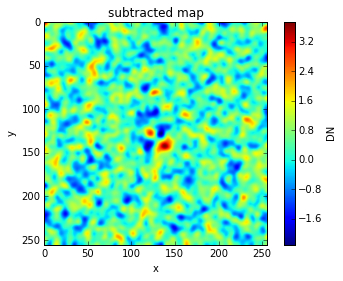

In [118]:
singl_subt = star_data - symm_2d_gaussian((x_arr,y_arr), *p_opt_singl)
smoothed_sub = ndimage.gaussian_filter(singl_subt, 3)
pyplot.imshow(smoothed_sub, origin='lower')
sub_plot = pyplot.imshow(smoothed_sub)
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title("subtracted map")
cbar = pyplot.colorbar(label='DN')
#cbar.solids.set_edgecolors('face')


Looking at the gaussian smoothed map of the residual, it does appear that this could very well be a binary star system!

<h4>Chi squared test on subtraction</h4>
$$\chi^2 = \sum_{x,y} \frac{\left(D_{xy}-f_{xy}\right)^2}{2\sigma^2}$$
$$\chi^2_{red} = \frac{\chi^2}{\nu}$$

In [49]:
def chi_square_(function, params, x_vals, data_vals, var_vals):
    residuals = (data_vals - function(x_vals, *params))
    chis = (residuals**2)/abs(var_vals)
    chi_sum = numpy.sum(chis)
    d_o_f = len(x_vals[0]) - len(params)
    return (chi_sum, d_o_f)


In [111]:
cs_singl, dof_singl = chi_square_(symm_2d_gaussian, p_opt_singl, (x_rav,y_rav), star_rav, star_rav)
red_cs_singl = cs_singl / dof_singl
print(red_cs_singl)


0.334679792458


<h4>Try to fit binary star</h4>

$$f_{bin}(x,y,\vec{z}) = F_1\exp\left[-\frac{(x-x_c-\frac{1}{2}r\sin\theta)^2 + (y-y_c-\frac{1}{2}r\cos\theta)^2}{2\sigma_{PSF}^2}\right] +  F_2\exp\left[-\frac{(x-x_c+\frac{1}{2}r\sin\theta)^2 + (y-y_c+\frac{1}{2}r\cos\theta)^2}{2\sigma_{PSF}^2}\right] + B$$


In [83]:
def binary_star(pos, F1, F2, xc, yc, rad, theta, sigma, B):
    f1 = F1*numpy.exp(-((pos[0]-(xc+rad*numpy.cos(theta)))**2+(pos[1]-(yc+rad*numpy.sin(theta)))**2)/(2*sigma**2))
    f2 = F2*numpy.exp(-((pos[0]-(xc-rad*numpy.cos(theta)))**2+(pos[1]-(yc-rad*numpy.sin(theta)))**2)/(2*sigma**2))
    return f1 + f2 + B
# should my radius be double this ?

In [48]:

sigma_array = numpy.sqrt(star_data)
sigma_rav = sigma_array.ravel()
bin_guess = (p_opt_singl[0]/2, p_opt_singl[0]/2, p_opt_singl[1], p_opt_singl[2], 5., numpy.pi/4., p_opt_singl[3], p_opt_singl[4])
p_opt_bin, p_cov_bin = optimize.curve_fit(binary_star, (x_rav,y_rav), star_rav, bin_guess, sigma_rav)

print(p_opt_bin)
print(p_cov_bin)


[  10.80603297   25.34271199  128.39125653  134.79728966    5.97064099
    0.77155851    6.11453469  133.0126394 ]
[[  1.95519089e+00  -6.27838234e-01  -4.57920283e-01  -4.45138775e-01
   -1.97182571e-01   4.25715397e-05  -1.24402940e-01   5.70375714e-04]
 [ -6.27838234e-01   1.57971650e+00   3.48449610e-01   3.38582061e-01
    2.41516919e-01  -3.68360354e-05  -7.32400540e-02  -1.78197840e-04]
 [ -4.57920283e-01   3.48449610e-01   2.26171076e-01   1.57178842e-01
    1.18717116e-01  -7.16291023e-03   1.66254296e-02  -3.12281637e-04]
 [ -4.45138775e-01   3.38582061e-01   1.57178842e-01   2.17113036e-01
    1.15264991e-01   7.30994145e-03   1.61875597e-02  -3.04169280e-04]
 [ -1.97182571e-01   2.41516919e-01   1.18717116e-01   1.15264991e-01
    1.14238732e-01  -2.37897997e-05   3.99607950e-03  -3.28262141e-04]
 [  4.25715397e-05  -3.68360354e-05  -7.16291023e-03   7.30994145e-03
   -2.37897997e-05   3.20097624e-03   4.43930505e-07  -3.94378347e-08]
 [ -1.24402940e-01  -7.32400540e-02   1

/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


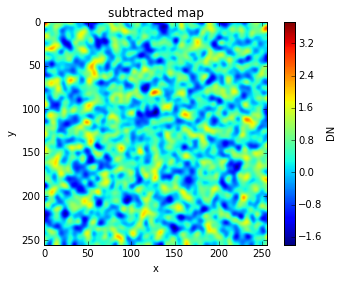

In [120]:
bin_subt = star_data - binary_star((x_arr,y_arr), *p_opt_bin)
smoothed_sub = ndimage.gaussian_filter(bin_subt, 3)
pyplot.imshow(smoothed_sub, origin='lower')
sub_plot = pyplot.imshow(smoothed_sub)
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title("subtracted map")
cbar = pyplot.colorbar(label='DN')

In [110]:
cs_bin, dof_bin = chi_square_(binary_star, p_opt_bin, (x_rav,y_rav), star_rav, star_rav)
red_cs_bin = cs_bin / dof_bin
print( red_cs_bin)


0.33426930894


The subtracted map looks much better and the chi square value goes down a bit, now let's do the likelihood ratio test to be more sure

<h3>Likelihood ratio test</h3>  

We would like to compare the likelihoods of the two models, over a range of possible parameters, not just the best fit parameters. From the notes:  
$$\frac{P\left(B \mid \{D_{x,y}\}\right)}{P\left(S \mid \{D_{x,y}\}\right)} = \frac{P\left(\{D_{x,y}\}\mid B\right)P\left(B\right)}{P\left(\{D_{x,y}\}\mid S\right)P\left(S\right)}$$  
The prior terms, $P\left(\left\{D_{x,y}\right\}\right)$, are the same in numerator and denominator, and cancel, since we're talking about the same data set.  
The likelihood terms for each model are found by integrating over the parameter space for that model:  
\begin{eqnarray}
P\left(\{D_{x,y}\}\mid M\right) &=& \int P\left(\{D_{x,y}\},\{\vec{z}_M\}\mid M\right)d\{\vec{z}_M\}\\
&=& \int P\left(\{D_{x,y}\}\mid \{\vec{z}_M\}, M\right)P\left(\{\vec{z}_M\}\mid M\right)d\{\vec{z}_M\}
\end{eqnarray}
The first term in the integrand, the probability of the data given a set of parameters, can be approximated as being a gaussian distributed centered around the best fit parameters, $\vec{z}_0$, in $n$-space where $n$ is the number of parameters for the model:  
\begin{eqnarray}
P\left(\{D_{x,y}\}, \vec{z}_M\mid M\right) &\approx& P\left(\{D_{x,y}\},\{\vec{z}_0\}\mid M\right)\exp{\left[-\frac{1}{2}\left(\vec{z}_M-\vec{z}_0\right)^T\Sigma^{\prime -1}\left(\vec{z}_M-\vec{z}_0\right)\right]}\\
\end{eqnarray}




In [117]:
F_max = 300 # DN
pix_width = len(x_arr[0])
param_diff = len(p_opt_bin) - len(p_opt_singl)
chi_s_diff = cs_singl - cs_bin
det_pcov_bin = numpy.linalg.det(p_cov_bin)
det_pcov_singl = numpy.linalg.det(p_cov_singl)

likelihood_ratio = numpy.power(2*pi, param_diff/2) / (pi * F_max * pix_width) * numpy.sqrt(det_pcov_bin/det_pcov_singl) * numpy.exp(chi_s_diff/2)
print(likelihood_ratio)

1.7311412615


<h3>Find the joint marginal distributions</h4>

In [84]:
def joint_marginal_dist(param_vals, opt_param_vals, cov_mat):
    for obj in [param_vals, opt_param_vals, cov_mat]:
        if type(cov_mat) is not numpy.matrix:
            cov_mat = numpy.matrix(cov_mat)
        vec = numpy.matrix(param_vals - opt_param_vals)
    return 1/((2*numpy.pi)*numpy.sqrt(numpy.linalg.det(cov_mat)))*numpy.exp(-0.5*vec.T*cov_mat.I*vec)
# mat1 * mat2 equivalent to numpy.dot(mat1, mat2)

<h5>Fluxes</h5>

In [86]:
F_points = 100
F1_arr = numpy.linspace(p_opt_bin[0]-5*p_cov_bin[0][0], p_opt_bin[0]+5*p_cov_bin[0][0], F_points)
F2_arr = numpy.linspace(p_opt_bin[1]-5*p_cov_bin[1][1], p_opt_bin[1]+5*p_cov_bin[1][1], F_points)

F1_arr, F2_arr = numpy.meshgrid(F1_arr, F2_arr)
coords = F1_arr, F2_arr

F1_rav = F1_arr.ravel()
F2_rav = F2_arr.ravel()


In [87]:
F0_matrix = numpy.matrix([[p_opt_bin[0]], [p_opt_bin[1]]])
sigma_F = p_cov_bin[0:2,0:2] # gets the mini 2x2 subarray 
F_rav_len = len(F1_rav)

if len(F1_rav) == F_points**2:
    fluxes_jm_prob_rav = numpy.zeros(F_rav_len)
    for i in range(0, F_rav_len):
        fluxes_jm_prob_rav[i] = joint_marginal_dist([[F1_rav[i]], [F2_rav[i]]], F0_matrix, sigma_F)


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


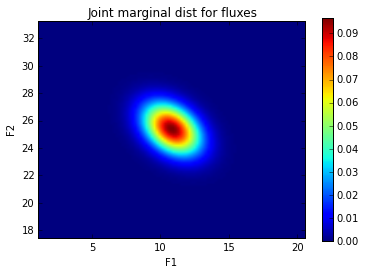

In [98]:
ext = [F1_arr.min(), F1_arr.max(), F2_arr.min(), F2_arr.max()]
pyplot.imshow(fluxes_jm_prob_rav.reshape(F_points, F_points), origin='lower', extent=ext) 
# origin='lower' to make standard x and y indices 
pyplot.title("Joint marginal dist for fluxes")
pyplot.xlabel("F1")
pyplot.ylabel("F2")
pyplot.colorbar()

In [99]:
l_points = 100
theta_arr = numpy.linspace(p_opt_bin[4]-5*p_cov_bin[4][4], p_opt_bin[4]+5*p_cov_bin[4][4], l_points)
r_arr = numpy.linspace(p_opt_bin[5]-5*p_cov_bin[5][5], p_opt_bin[5]+5*p_cov_bin[5][5], l_points)

theta_arr, r_arr = numpy.meshgrid(theta_arr, r_arr)

theta_rav = theta_arr.ravel()
r_rav = r_arr.ravel()


In [100]:
rtheta_matrix = numpy.matrix([[p_opt_bin[4]], [p_opt_bin[5]]])
sigma_rtheta = p_cov_bin[4:6,4:6] # gets the mini 2x2 subarray 
theta_rav_len = len(theta_rav)

if len(theta_rav) == l_points**2:
    rtheta_jm_prob_rav = numpy.zeros(theta_rav_len)
    for i in range(0, theta_rav_len):
        rtheta_jm_prob_rav[i] = joint_marginal_dist([[theta_rav[i]], [r_rav[i]]], rtheta_matrix, sigma_rtheta)


[5.3994473271760182, 6.541834645497616, 0.7555536261095871, 0.7875633884827441]


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


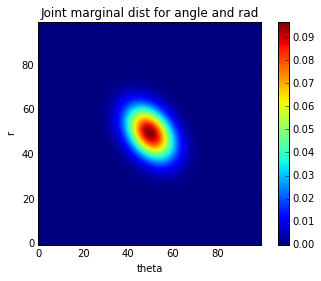

In [123]:
ext = [theta_arr.min(), theta_arr.max(), r_arr.min(), r_arr.max()]
print(ext)
fluxes_jm_prob = fluxes_jm_prob_rav.reshape(l_points, l_points)
pyplot.imshow(fluxes_jm_prob, origin='lower') # , extent=ext
# origin='lower' to make standard x and y indices 
pyplot.title("Joint marginal dist for angle and rad")
pyplot.xlabel("theta")
pyplot.ylabel("r")
pyplot.colorbar()


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


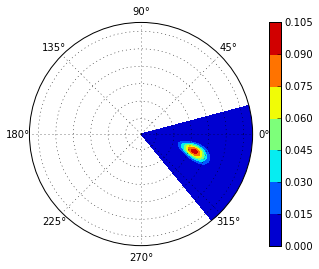

In [125]:
ax = pyplot.subplot(111, polar=True)
ax.set_yticklabels([])
ctf = ax.contourf(theta_arr, r_arr, fluxes_jm_prob, cmap=cm.jet)
pyplot.colorbar(ctf)

Gain stuff

In [ ]:
k = 3.0 # gain 
star_data_pe = k * star_data


Other: the binary fit was really poor when done in cartesian coords

In [126]:
def binary_star_0(pos, F1, xc1, yc1, sigma1, F2, xc2, yc2, sigma2, B):
    return F1*numpy.exp(-((pos[0]-xc1)**2+(pos[1]-yc1)**2)/(2*sigma1**2)) + F2*numpy.exp(-((pos[0]-xc2)**2+(pos[1]-yc2)**2)/(2*sigma2**2)) + B
    
init_guess_0 = (11., 130, 130, 15, 25., 130, 130, 15, 100)
p_opt_bin_0, p_cov_bin_0 = optimize.curve_fit(binary_star_0, (x_rav, y_rav), star_rav, init_guess_0, sigma_rav)

print(p_opt_bin_0)

[ -6.01024263e+04   2.00723358e+02  -2.42144960e+00   3.27414541e+04
   6.00843270e+04   1.60189936e+02   6.88888696e+01  -2.20944676e+04
   1.51250098e+02]


In [52]:
from functools import partial
#part_func = partial(symm_2d_gaussian, pos)

# do it the simple way 
chi_s = numpy.sum(blank_sky**2/star_data)
dof = len(x_rav) - len(p_opt_singl)
print(chi_s / dof)

0.334679792458



= \begin{bmatrix}
    \dfrac{\partial f_1}{\partial x_1} & \cdots & \dfrac{\partial f_1}{\partial x_n}\\
    \vdots & \ddots & \vdots\\
    \dfrac{\partial f_m}{\partial x_1} & \cdots & \dfrac{\partial f_m}{\partial x_n} \end{bmatrix}

